# Apply Neural Networks to the Stock Market

Notebook to explore limited set of NY stock exchange data over around 40 years, as part of the Portland Data Science group (Mar 2018).
Data selected by Matt Borthwick from Yahoo! Finance.
Working with Neural Network group: Matt, John Burt, Manny, Isil, Kenny, Jhoan, Mark C.

Our goal is to predict weekly returns on 6 industry based ETFs, as well
as aggregate market performance (such as Russel3000).  We will also
be using some macroeconomic indicators as well.
This notebook currently loads the data, transforms it, and applies a
simple neural network to try predicting the next days stock prices.

The plan is to train on this data (up to Sep 2017),
validate on (Oct-Dec 2017), and test in final session on (Jan-Mar 2018).

(For more exploratory screwing around, and other attempts at time-series see PDX_finance1)

# Google Colab setup

First up however, we need to install modules to load up our google drive for storage.  (Code taken from this helpful post https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d)
(Code and commands didn't look sketchy/malicious, but I didn't examine the PPA too closely either.)

This code is for execution inside a Jupyter notebook on colab.google.com.
It gives Colab access to your Google Drive in order to load/save data from within the notebook.
Colab has most popular libraries (numpy, pandas, tensorflow, matplotlib).  I'm not sure how extensive it is.

I've found opening a jupyter notebook on google drive automatically opens the Colab.

In [ ]:
#Install modules on local machine.
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!echo 'past update'
!apt-get -y install -qq google-drive-ocamlfuse fuse
!echo 'installed fuse'

In [ ]:
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
print('past first command')
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

In [ ]:
#Mounts google drive, and changes to that directory
!mkdir -p drive 
!google-drive-ocamlfuse drive

import os
os.chdir("drive")

#Should now be in the root of your google-drive, and now free to load/save existing files.

# Load Libraries and Data

Now to load libraries, and data.  (This is where I start my analysis
                                   on my home machine.)

In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
# automatically reload files.
%load_ext autoreload
%autoreload 2

In [18]:
#Data compiled from Yahoo! Finance data by Matt Borthwick
df_close=pd.read_csv('data/stocks-us-adjClose.csv',index_col=0,parse_dates=True)
df_high=pd.read_csv('data/stocks-us-adjHigh.csv',index_col=0,parse_dates=True)
df_low=pd.read_csv('data/stocks-us-adjLow.csv',index_col=0,parse_dates=True)
df_vol=pd.read_csv('data/stocks-us-Volume.csv',index_col=0,parse_dates=True)
df_close.index.name='Time'
df_high.index.name='Time'
df_low.index.name='Time'
df_vol.index.name='Time'

In [19]:
#Make a combined 
panel=pd.Panel({'close':df_close,'low':df_low,'high':df_high,'vol':df_vol})

In [20]:
panel.loc[:,'2016','ED']

                close       high        low        vol
Time                                                  
2016-01-04  60.483231  60.502011  59.609792  1687600.0
2016-01-05  60.962212  61.206393  59.713100  1516600.0
2016-01-06  61.253365  61.488160  60.295397  1681100.0
2016-01-07  61.722950  61.948351  60.577149  3372900.0
2016-01-08  62.389763  62.737263  61.722946  5463900.0
2016-01-11  62.277065  63.347730  62.145580  4279500.0
2016-01-12  61.516335  62.633962  61.150055  3140100.0
2016-01-13  62.624561  62.915705  61.600850  3214900.0
2016-01-14  63.507389  63.854881  62.061050  3882800.0
2016-01-15  63.563732  63.742179  62.455499  3838600.0
2016-01-19  64.869202  65.047648  63.535567  3372100.0
2016-01-20  64.099083  64.850430  63.610712  3398500.0
2016-01-21  63.573132  64.784676  62.173748  4585700.0
2016-01-22  63.836113  64.164825  62.615175  3143700.0
2016-01-25  63.685841  64.080302  63.375916  2131300.0
2016-01-26  63.854885  64.934944  63.554347  2108700.0
2016-01-27

In [23]:
Nstocks=df.shape[1]-np.isnan(df).sum(axis=1)

In [25]:
#Plot number of stocks

plt.figure()
plt.plot(Nstocks['2010':])
plt.show()


In [ ]:
Looking at the number of NA values (summed across columns) suggests that
there are missing values in these stocks.

Could set all NA to zero, then apply linear interpolation to handle isolated
missing days.

# Neural Network

This model is just a test based purely on the stock data.
The network uses a multi-layer RNN, with two hidden layers at input/output.  They use leaky ReLU activation.
The model currently plays with 100 stocks from 2002-2006.

This uses a model I've cobbled together in Tensorflow.
The OO structure is borrowed from the online problem sets
from CS224 on NLP offered in 2017 at Stanford.
The NN is borrowed from A. Geron "Hands on Machine Learning with Scikit-Learn and Tensorflow", which I've found to be the best
overall introduction, and has a good mix of background, and code.
(Note there is an associated Github account with code).

The Tensorflow docs were pretty hard reading, and there seem to be lots
of tricks that only practitioners on StackOverflow are aware of.  (But the tutorials are pretty readable.)


In [24]:
import tensorflow as tf
from recurrent_network import recurrent_NN

# Data Transformation

For the initial testing, I'm just building a model based on the 100 oldest stocks (or whichever come first), and looking at 2002-2006.
Why then?  Because it looks relatively well behaved.
The model is trained on the first half of the data, and we then run the
network on the whole data set.

I'm currently just taking the base-10 log of the data, and scaling each
stock to lie with [-1,1].  I found differencing the data lead to
pretty crappy results (then again, these are also pretty crap results).

So there's some choices to be played with here:
- scaling: variance vs max/min
- differencing?

In [221]:
Nstocks=200
Xsub=panel.loc['close','1999':'2006'].iloc[:,:Nstocks].values

def scale_clean_data(X):
    #set missing values to zero.  (to avoid issues in network with NaNs)
    X[np.isnan(X)]=0
    #take differences of logs. (shift zero to avoid NANs)
    #Xsub2 = np.diff(np.log10(Xsub+1E-12),axis=0)
    X = np.log10(Xsub+1E-16)

    X_max = np.max(X,axis=0)
    X_min = np.min(X,axis=0)

    #Choice of scaling here: max/min vs variance?
    #I think variance makes more sense if differencing.
    rng = 0.5*(X_max-X_min)
    avg = 0.5*(X_max+X_min)
    Xscaled= (X-avg)/rng
    return Xscaled,rng,avg

Xsub2,rng,avg=scale_clean_data(Xsub)

#split 3/4 as training, 1/4 as test
N=len(Xsub2)
Nc=int(3*N/4)
#make training/test splits
Xtrain = Xsub2[:Nc]
ytrain = Xsub2[1:Nc+1] #tomorrow's return.

Xtest=Xsub2[Nc:-1]
ytest=Xsub2[Nc+2:]

In [225]:
#check scaling
plt.figure()
plt.plot(Xtrain[:,0:5])
plt.plot(ytrain[:,0:5])
plt.show()

# Fitting RNN

In [23]:
#define network.
#Note a lot of network parameters are defined in __init__ in "recurrent_network.py".
#A more robust structure would pass a config dict or something like that.
RNN=recurrent_NN(60,Nstocks,100,Nstocks,'LSTM')

NameError: name 'recurrent_NN' is not defined

iter #200. Current MSE:0.006282703019678593
Total Time taken:111.33165669441223




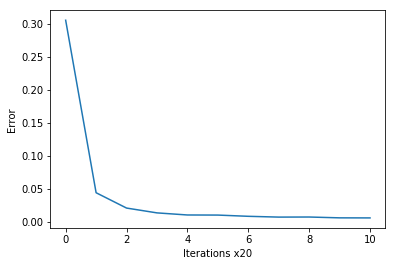

In [9]:
#Rebuild the tensorflow graph.
RNN.build()
#Actually train the graph on first half of data.
#Give all of the data to this subroutine, where it selects
# the inputs and target data in get_random_batch


RNN.train_graph(Xtrain,Xtrain,save_name='tf_models/rnn_test')
#Note the tiny, tiny errors.  Probably badly overfitting.
#Need to fix the dropout so it's only on in training.

In [10]:
#Predict on all of the data.
#This loads up a previous model.
RNN_pred=RNN.predict_all('tf_models/rnn_test',200,Xsub2,reset=True)

INFO:tensorflow:Restoring parameters from tf_models/rnn_test-200
0 100
100 200
200 300
300 400
400 500
500 600
600 700
700 800
800 900
900 1000
1000 1100


In [11]:
def plot_pred(X,pred,indx_range):
    """Plots a particular stock and the prediction"""

    plt.figure()
    plt.subplot(121)
    plt.plot(X[:,indx_range])
    plt.plot(pred[:,indx_range])
    plt.plot([len(X)/2]*2,[-1,1],'k-')
    plt.legend(['Actual','Forecast'])
    plt.title('Raw')

    plt.subplot(122)
    plt.plot(np.cumsum(X[:,indx_range],axis=0))
    plt.plot(np.cumsum(pred[:,indx_range],axis=0))
    plt.legend(['Actual','Forecast'])    
    plt.title('Cumulative')

    plt.show()
    

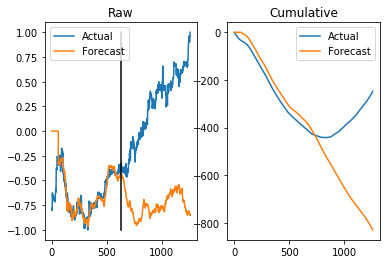

In [17]:
#Could make predicted results a time series for nicer formating, and dates.
#Plot cumulative for cases when we've also differenced.
plot_pred(Xsub2,RNN_pred,50)

This RNN forecast is also WAY worse than a persistence forecast (tomorrow's price is the same as todays).
Big question: why is the price wandering away? Even if the model is fixed (weights unchanged), surely it should take the recent past (which the model uses to forecast tomorrow's demand) into account.  

Note the effect of further smoothing, which suggests a clearer trend, that might be easier to model.
That suggests the convolutional networks may be useful,
perhaps with running averages to smooth the data.  Forecasting on a week timescale might allevative some of that too?

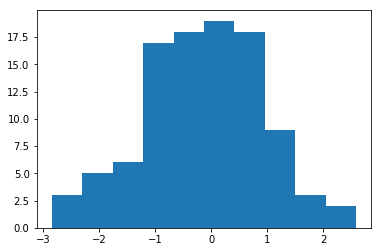

In [13]:
#Let's look at the differences between the predicted and actual
#results at the end of the period.
pred_diff=RNN_pred[-1]-Xsub2[-1]
plt.hist(pred_diff)
plt.show()

In [15]:
(np.mean(pred_diff),np.std(pred_diff))

(-0.1433746024133806, 1.0660086500156463)

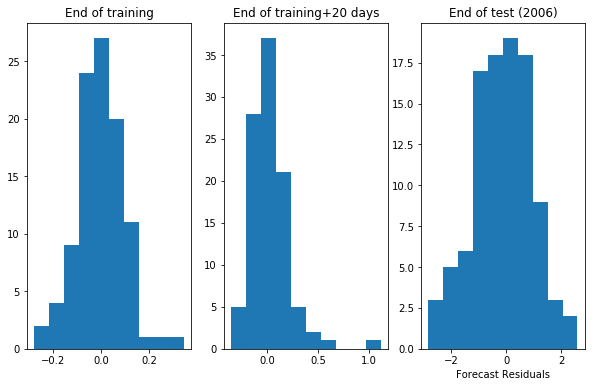

In [16]:
#Let's now see how much the predictions vary (across all stocks) at the end of training, 20 trading days after that,
# and at the end of the period, a year or two out.

#Note that these predictions use the data from those periods, but the model is not being updated.

Nc = int(len(Xsub2)/2)
plt.figure(figsize=(10,6))
plt.subplot(131)
pred_diff=RNN_pred[Nc]-Xsub2[Nc]
plt.title('End of training')
plt.hist(pred_diff)


plt.subplot(132)
pred_diff=RNN_pred[Nc+20]-Xsub2[Nc+20]
plt.title('End of training+20 days')
plt.hist(pred_diff)

plt.subplot(133)
pred_diff=RNN_pred[-1]-Xsub2[-1]
plt.hist(pred_diff)
plt.title('End of test (2006)')
plt.xlabel('Forecast Residuals')
plt.show()


The final graph is worst, it is also trying to predict many years ahead, based on essentially short-term info.
Probably could describe build up of cumulative errors as a random walk?
Would guess errors grows as sqrt(T), so the variance of this distribution grows as T.



# Keras Network

Let's build a similar recurrent network in Keras (just using the adjusted close for now).

In [112]:
#Borrowing some from Keras docs, and "https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/"
import keras  
from keras.models import Sequential 
from keras.layers import Dense, RNN, LSTM, StackedRNNCells
from keras.losses import mean_squared_error, mean_absolute_error

In [189]:
Nstock=200
Nfeature=1
Ninput=Nstock*Nfeature
Nlayers=1
Ntime=60
Nhidden=10
Nepoch=20
Nbatch=50
Noutput=Nstock*Nfeature

In [65]:
A=np.arange(24).reshape([2,3,4])

In [121]:
def new_LSTM_cell(units):
    return LSTM(units=units,activation='relu',
                    kernel_initializer='he_normal',
                    dropout=0.5, recurrent_dropout=0.5,
                    return_sequences=True,return_states=True)

##Code to add a list of RNN cells
# stacked_cells=[];
# for i in range(Nlayers):
#     stacked_cells.append(add_LSTM_cell(Nhidden))
# model.add(StackedRNNCells(stacked_cells))


In [191]:
#note: this relies on looking up global parameters (blech)
def get_random_batch(Nbatch,X,y):
    #starting indices
    ind=np.arange(len(X[:,0])-Ntime)
    rand_ind=np.random.choice(ind,Nbatch,replace=False)
    Xb=np.zeros((Nbatch,Ntime,Ninput))
    yb=np.zeros((Nbatch,Noutput))    
    for i in range(Nbatch):
        Xb[i]=X[rand_ind[i]:rand_ind[i]+Ntime,:]
        yb[i]=y[rand_ind[i]+Ntime,:]
    return Xb,yb

In [227]:
#make a Keras model two layer LSTM, with dense input/outputs
del model
keras.backend.clear_session()
model=Sequential()
model.add(Dense(units=Nhidden, activation=None, input_shape=(Ntime,Ninput))) #linear mapping at input
model.add(LSTM(units=Nhidden,activation='relu',
                    dropout=0.5, recurrent_dropout=0.5,return_sequences=True))
model.add(LSTM(units=Nhidden,activation='relu',
                    dropout=0.5, recurrent_dropout=0.5,return_sequences=False))
#linear mapping at output
model.add(Dense(units=Noutput,activation=None,input_shape=(Ntime,Nhidden))) #output layer
model.compile(optimizer='adam',loss=mean_absolute_error)

In [204]:
%pdb off

Automatic pdb calling has been turned OFF


In [215]:
(Nout)

100

In [240]:
for i in range(100):
    Xb,yb=get_random_batch(Nbatch,Xtrain,ytrain)
    model.fit(Xb,yb, epochs=1,batch_size=Nbatch,verbose=1)  

Epoch 1/1
50/50 [==============================] - 0s 4ms/step - loss: 0.3603


50/50 [==============================] - 0s 4ms/step - loss: 2602.6147


Epoch 1/1


50/50 [==============================] - 0s 4ms/step - loss: 653.0090


Epoch 1/1


50/50 [==============================] - 0s 4ms/step - loss: 0.3525


Epoch 1/1

50/50 [==============================] - 0s 4ms/step - loss: 12.0831


Epoch 1/1


50/50 [==============================] - 0s 4ms/step - loss: 2.2581


Epoch 1/1


Epoch 1/1
50/50 [==============================] - 0s 4ms/step - loss: 0.3376


50/50 [==============================] - 0s 5ms/step - loss: 0.4956


Epoch 1/1


50/50 [==============================] - 0s 4ms/step - loss: 31709.7070


Epoch 1/1


50/50 [==============================] - 0s 4ms/step - loss: 6764.0713


Epoch 1/1


Epoch 1/1
50/50 [==============================] - 0s 4ms/step - loss: 961.4249


50/50 [==============================] - 0s 4ms/step - loss: 80109.8281


Epoch 1/1


50/50 [==============================] - 0s 4ms/step - loss: 1.0240


Epoch 1/1


Epoch 1/1
50/50 [==============================] - 0s 4ms/step - loss: 4.0620


50/50 [==============================] - 0s 4ms/step - loss: 1.5167


Epoch 1/1


Epoch 1/1
50/50 [==============================] - 0s 4ms/step - loss: 0.3765


50/50 [==============================] - 0s 5ms/step - loss: 68.1141


Epoch 1/1


Epoch 1/1
50/50 [==============================] - 0s 4ms/step - loss: 0.7519


50/50 [==============================] - 0s 4ms/step - loss: 0.4758


Epoch 1/1


50/50 [==============================] - 0s 4ms/step - loss: 27.7471


Epoch 1/1


Epoch 1/1
50/50 [==============================] - 0s 4ms/step - loss: 377.8414


50/50 [==============================] - 0s 4ms/step - loss: 348218.4688


Epoch 1/1


50/50 [==============================] - 0s 4ms/step - loss: 150.4018


Epoch 1/1


Epoch 1/1
50/50 [==============================] - 0s 3ms/step - loss: 10.2598


50/50 [==============================] - 0s 4ms/step - loss: 5.3529


Epoch 1/1


Epoch 1/1
50/50 [==============================] - 0s 4ms/step - loss: 8.7357


50/50 [==============================] - 0s 5ms/step - loss: 78370.8203


Epoch 1/1


50/50 [==============================] - 0s 4ms/step - loss: 2.1768


Epoch 1/1


Epoch 1/1
50/50 [==============================] - 0s 4ms/step - loss: 4735.0288


50/50 [==============================] - 0s 4ms/step - loss: 0.3415


Epoch 1/1


Epoch 1/1
50/50 [==============================] - 0s 4ms/step - loss: 0.3608


50/50 [==============================] - 0s 4ms/step - loss: 175.1248


Epoch 1/1


50/50 [==============================] - 0s 4ms/step - loss: 0.7193


Epoch 1/1


Epoch 1/1
50/50 [==============================] - 0s 4ms/step - loss: 213.0600


50/50 [==============================] - 0s 4ms/step - loss: 0.8536


Epoch 1/1


Epoch 1/1
50/50 [==============================] - 0s 4ms/step - loss: 214358.3438


50/50 [==============================] - 0s 4ms/step - loss: 0.4897


Epoch 1/1


50/50 [==============================] - 0s 4ms/step - loss: 55.3907


Epoch 1/1


Epoch 1/1
50/50 [==============================] - 0s 3ms/step - loss: 417.2599


50/50 [==============================] - 0s 4ms/step - loss: 0.3517


Epoch 1/1


Epoch 1/1
50/50 [==============================] - 0s 4ms/step - loss: 2.4223


50/50 [==============================] - 0s 4ms/step - loss: 34252.8438


Epoch 1/1


50/50 [==============================] - 0s 4ms/step - loss: 36852.6758


Epoch 1/1


50/50 [==============================] - 0s 4ms/step - loss: 25.4370


Epoch 1/1


Epoch 1/1
50/50 [==============================] - 0s 4ms/step - loss: 2386.1367


50/50 [==============================] - 0s 5ms/step - loss: 6783.9111


Epoch 1/1


 - 0s 4ms/step - loss: 0.4850


50/50 [==============================]

Epoch 1/1


50/50 [==============================] - 0s 4ms/step - loss: 0.9760


Epoch 1/1


50/50 [==============================] - 0s 4ms/step - loss: 0.9620


Epoch 1/1


Epoch 1/1
50/50 [==============================] - 0s 4ms/step - loss: 0.3536


50/50 [==============================] - 0s 4ms/step - loss: 2.1830


Epoch 1/1


50/50 [==============================] - 0s 4ms/step - loss: 0.5742


Epoch 1/1


Epoch 1/1
50/50 [==============================] - 0s 4ms/step - loss: 0.3250


50/50 [==============================] - 0s 4ms/step - loss: 58.2531


Epoch 1/1


Epoch 1/1
50/50 [==============================] - 0s 4ms/step - loss: 67.5834


50/50 [==============================] - 0s 4ms/step - loss: 66.0516


Epoch 1/1


50/50 [==============================] - 0s 4ms/step - loss: 4420837.5000


Epoch 1/1


50/50 [==============================] - 0s 4ms/step - loss: 728371.2500


Epoch 1/1


50/50 [==============================] - 0s 4ms/step - loss: 6.8328


Epoch 1/1


Epoch 1/1
50/50 [==============================] - 0s 4ms/step - loss: 1.0557


50/50 [==============================] - 0s 4ms/step - loss: 533.1860


Epoch 1/1


50/50 [==============================] - 0s 4ms/step - loss: 2911393792.0000


Epoch 1/1


Epoch 1/1
50/50 [==============================] - 0s 4ms/step - loss: 110041.1328


50/50 [==============================] - 0s 4ms/step - loss: 0.5620


Epoch 1/1


50/50 [==============================] - 0s 4ms/step - loss: 11906.3779


Epoch 1/1


50/50 [==============================] - 0s 5ms/step - loss: 0.4206


Epoch 1/1


50/50 [==============================] - 0s 4ms/step - loss: 0.5365


Epoch 1/1

Epoch 1/1
50/50 [==============================] - 0s 4ms/step - loss: 0.4172


50/50 [==============================] - 0s 4ms/step - loss: 12120.2637


Epoch 1/1


Epoch 1/1
50/50 [==============================] - 0s 4ms/step - loss: 274.8556


50/50 [==============================] - 0s 4ms/step - loss: 719.2906


Epoch 1/1


50/50 [==============================] - 0s 4ms/step - loss: 0.5103


Epoch 1/1



50/50 [==============================] - 0s 4ms/step - loss: 0.4821


Epoch 1/1

 - 0s 4ms/step - loss: 602275.2500


Epoch 1/1
50/50 [==============================]

50/50 [==============================] - 0s 4ms/step - loss: 10.1755


Epoch 1/1


50/50 [==============================] - 0s 5ms/step - loss: 9835.0684


Epoch 1/1


50/50 [==============================] - 0s 4ms/step - loss: 0.3544


Epoch 1/1


50/50 [==============================] - 0s 4ms/step - loss: 0.6768


Epoch 1/1


50/50 [==============================] - 0s 4ms/step - loss: 0.4504


Epoch 1/1


Epoch 1/1
50/50 [==============================] - 0s 3ms/step - loss: 0.4454


50/50 [==============================] - 0s 5ms/step - loss: 585416.0625


Epoch 1/1


50/50 [==============================] - 0s 4ms/step - loss: 0.3112


Epoch 1/1


Epoch 1/1
50/50 [==============================] - 0s 4ms/step - loss: 1197664.0000


50/50 [==============================] - 0s 6ms/step - loss: 1.4095


Epoch 1/1


50/50 [==============================] - 0s 5ms/step - loss: 0.4147


Epoch 1/1


50/50 [==============================] - 0s 4ms/step - loss: 788.7443


Epoch 1/1


50/50 [==============================] - 0s 4ms/step - loss: 479787.7188


Epoch 1/1


Epoch 1/1
50/50 [==============================] - 0s 4ms/step - loss: 20578.4102


50/50 [==============================] - 0s 4ms/step - loss: 0.7632


Epoch 1/1


50/50 [==============================] - 0s 5ms/step - loss: 1.5010


Epoch 1/1


 - 0s 4ms/step - loss: 0.8589


50/50 [==============================]

Epoch 1/1


50/50 [==============================] - 0s 5ms/step - loss: 1.4997


Epoch 1/1


Epoch 1/1
50/50 [==============================] - 0s 3ms/step - loss: 78950.2188


50/50 [==============================] - 0s 4ms/step - loss: 324453.7500


Epoch 1/1


 - 0s 4ms/step - loss: 0.5882


50/50 [==============================]

Epoch 1/1


Epoch 1/1
50/50 [==============================] - 0s 4ms/step - loss: 11660.5908


50/50 [==============================] - 0s 4ms/step - loss: 0.5847


Epoch 1/1


Epoch 1/1
50/50 [==============================] - 0s 4ms/step - loss: 2.8004


50/50 [==============================] - 0s 5ms/step - loss: 15.3715


Epoch 1/1


Epoch 1/1
50/50 [==============================] - 0s 4ms/step - loss: 0.4307


In [234]:
X2=Xtrain.reshape([1,Xtrain.shape[0],Xtrain.shape[1]])

In [235]:
#for prediction reshape the whole thing from length Tf, to a batches of




(1, 1508, 200)

In [267]:
Nf = len(Xtrain)-Ntime
ypred_tot=np.zeros((Nf,Noutput))
i0=0
i1=Nbatch
#split whole time sequence into sequential batches.
while (i1 < Nf):
    print(i0)
    X0=np.zeros((Nbatch,Ntime,Ninput))
    for i in range(Nbatch):
        X0[i]=Xtrain[i0+i:i0+i+Ntime]
    ypred_tot[i0:i1]=model.predict(X0,batch_size=Nbatch)        
    i0=i1
    i1+=Nbatch

Nrem=Nf-i0
X0=np.zeros((Nrem,Ntime,Ninput))
for i in range(Nrem):
    X0[i]=Xtrain[i0+i:i0+i+Ntime]

ypred[-Nrem:]=model.predict(X0,batch_size=Nbatch)


1150
1200
1250
1300
1350


850
900
950
1000
1050
1100


600
650
700
750
800


300
350
400
450
500
550


0
50
100
150
200
250


In [272]:
plt.plot(ypred[:,0:20])
plt.show()

1448

1508

In [32]:
?Dense